<h1 style="color: #00BFFF;">00 |</h1>

After sleeping through a hundred million centuries
We have finally opened our eyes on a sumptuous planet, sparkling with color, bountiful with life.

Within decades we must close our eyes again... Isn't it a noble and enlightened way of spending our brief time in the sun? To work at understanding the universe and how we have come to wake up in it?

― Richard Dawkins

In [1]:
# 📚 Basic libraries
import os # file managment
import numpy as np # numerical python
import pandas as pd # dataframe managment

# 📊 Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image # Image data visualization module from Python Imaging Library

# 📦 Others
import warnings # who likes warnings?
import shutil # images folder managment
import random # random samples

# 🌐 Computer Vision 
import tensorflow as tf # machine learning
from tensorflow import keras # neural networks; it runs on top of TensorFlow
from tensorflow.keras import layers # sets of neurons
from tensorflow.keras.models import load_model # to load the saved epoch

# 🧮 Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix # classification performance and confussion matrix

In [2]:
# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings

In [3]:
# 🎯 Specific functions
def make_model(input_shape, num_classes): # adapted from Keras Image Classification from scratch tutorial
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

<h1 style="color: #00BFFF;">01 | Data Extraction</h1>

In [4]:
data_path = os.path.join(os.getcwd(), "00_data") # string with current directory + data folder

solution_file = os.path.join(data_path, 'training_solutions_rev1.csv') # CSV with galaxy classifications
training_images = os.path.join(data_path, "images_training_rev1") # training images
test_images = os.path.join(data_path, "images_test_rev1") # test images|

<h3 style="color: #008080;">The Hubble sequence</h3>

The **Hubble sequence** is a morphological classification for galaxies, published by [Edwin Hubble](https://en.wikipedia.org/wiki/Edwin_Hubble) in 1926, dividing regular galaxies in three main classes; ellpipticals, lenticulars and **spirals**.

Spiral galaxies, which are abundant in the universe, display a distinctive disk with spiraling arms and a gas and dust-rich central bulge. Studying spiral galaxies gives us a peek into the universe's past and helps us understand galaxy evolution and cosmology.

The **Galaxy Zoo** involved human volunteers for visual and pattern recognition through a decision-tree process, answering questions progresseviely about a galaxy's structure.

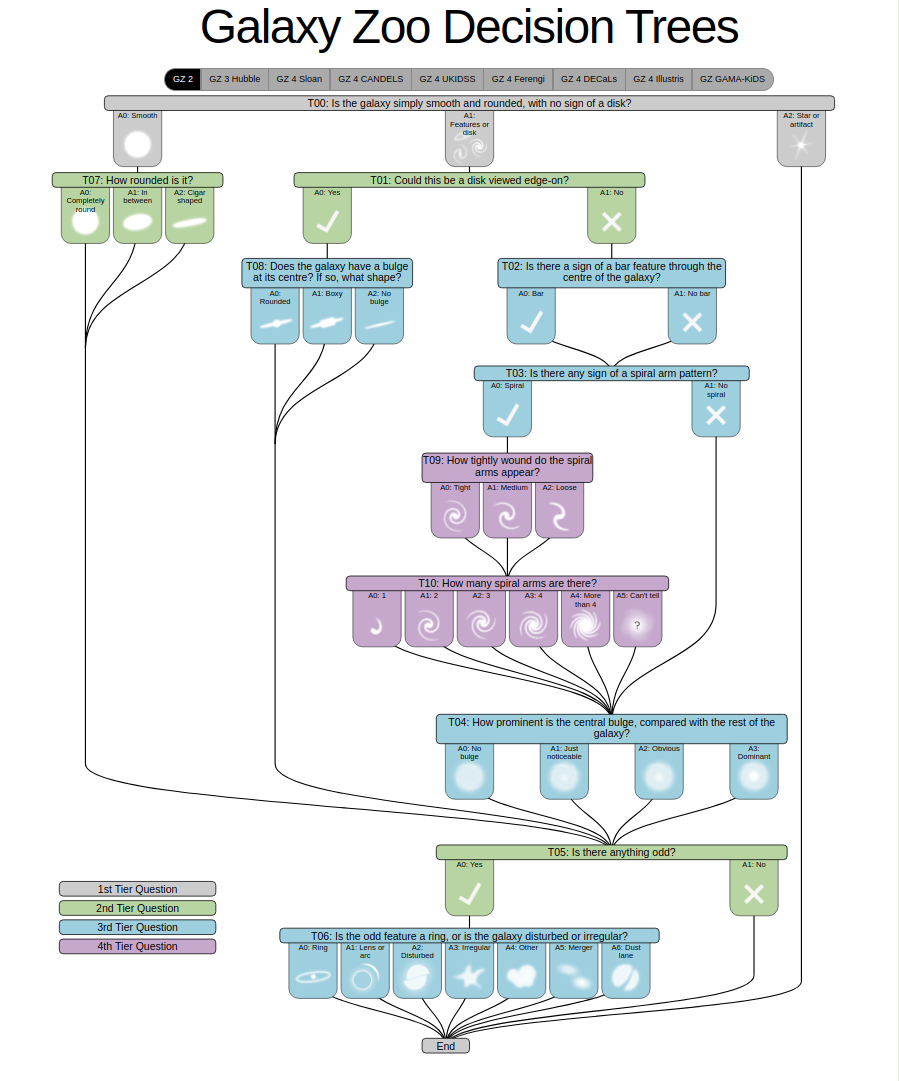

In [5]:
# read csv
df = pd.read_csv(solution_file)
df.columns = [col.lower().replace('.', '_') for col in df.columns] # the good old habits
df.head(5)

,galaxyid,class1_1,class1_2,class1_3,class2_1,class2_2,class3_1,class3_2,class4_1,class4_2,class5_1,class5_2,class5_3,class5_4,class6_1,class6_2,class7_1,class7_2,class7_3,class8_1,class8_2,class8_3,class8_4,class8_5,class8_6,class8_7,class9_1,class9_2,class9_3,class10_1,class10_2,class10_3,class11_1,class11_2,class11_3,class11_4,class11_5,class11_6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027227,0.000000,0.027227,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


<h1 style="color: #00BFFF;">02 | Data Pre-processing</h1>

<h3 style="color: #008080;">Defning the threshold for spiral galaxies</h3>

In [6]:
# 'class1_2' represents the probability of the galaxy having features or a disk
# 'class4_1' is the probability of having a visible bulge
# 'class6_1' is the probability of seeing a spiral arm pattern

# Any galaxy that has 50% > will be considered a spiral
s_threshold  = (df['class1_2'] > 0.5) & (df['class4_1'] > 0.5) & (df['class6_1'] > 0.5)
spirals = df[s_threshold][['galaxyid']]

# Any galaxy that has <= 50% will be considered a non-spiral
n_threshold = (df['class1_2'] <= 0.5) | (df['class4_1'] <= 0.5) | (df['class6_1'] <= 0.5)
non_spirals = df[n_threshold][['galaxyid']]

In [7]:
spirals.head(10)

,galaxyid
8,100134
127,101756
162,102243
176,102474
276,104001
393,105774
537,107627
543,107709
569,108038
606,108742


In [8]:
# Create a combined DataFrame just to compare
data = pd.concat([spirals, non_spirals]).drop_duplicates().reset_index(drop=True)

# Add the 'spiral' and 'non_spiral' columns
data['spiral'] = data['galaxyid'].isin(spirals['galaxyid']).astype(int)
data['non_spiral'] = data['galaxyid'].isin(non_spirals['galaxyid']).astype(int)
data.head(5)

,galaxyid,spiral,non_spiral
0,100134,1,0
1,101756,1,0
2,102243,1,0
3,102474,1,0
4,104001,1,0


In [9]:
# Obssesive checker is me
non_spiral_check = data[data['spiral'] == 0] # Just to visualize non_spiral
non_spiral_check.head(5)

,galaxyid,spiral,non_spiral
1549,100008,0,1
1550,100023,0,1
1551,100053,0,1
1552,100078,0,1
1553,100090,0,1


<h3 style="color: #008080;">New directories for spirals and non-spirals galaxies</h3>

In [10]:
spirals_dir = os.path.join(data_path, "spirals")
non_spirals_dir = os.path.join(data_path, "non_spirals")

# Making sure new directories do not overwrite previous ones ~ Sabina awesomeness
os.makedirs(spirals_dir, exist_ok=True)
os.makedirs(non_spirals_dir, exist_ok=True)

<h3 style="color: #008080;">Copying training images to their new directories based on the labels</h3>

In [13]:
for image_file in os.listdir(training_images):
    # Extracting the galaxy_id
    galaxy_id = int(os.path.splitext(image_file)[0]) # splitext to get galaxy_id and .jpg, we select [0] = id and convert it to an integer
    source = os.path.join(training_images, image_file)
    if galaxy_id in spirals.values:
        dest = os.path.join(spirals_dir, image_file)
    elif galaxy_id in non_spirals.values:
        dest = os.path.join(non_spirals_dir, image_file)
    else:
        continue  # if galaxy_id is not classified as either, do not copy the file
    shutil.copy(source, dest) # copying files from their source to the new destinations
    
# We use shutil.copy instead of .move because moving the images erased them from previous directories, and sometimes that triggered some errors when I had to run the code again after making some changes

Sample spiral galaxy images:


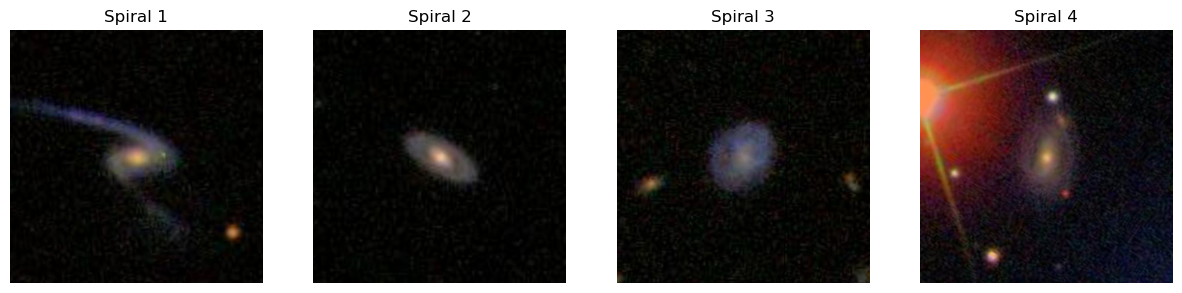


Sample non-spiral galaxy images:


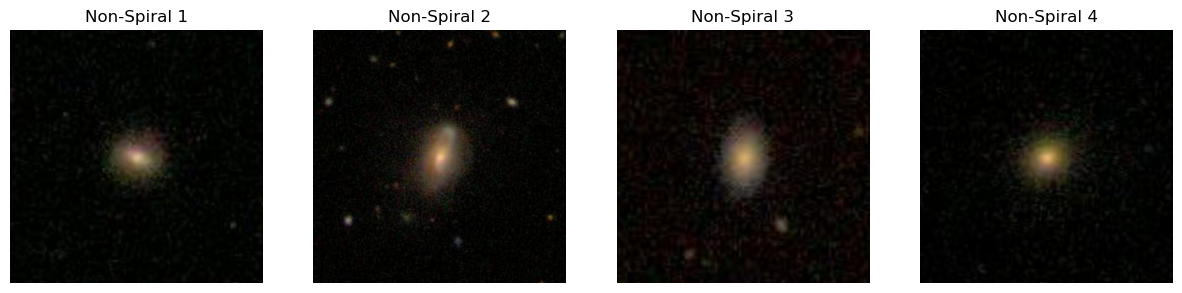

In [11]:
# Sample spiral galaxy images
print("Sample spiral galaxy images:")
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
random_spiral_images = random.sample(os.listdir(spirals_dir), 4)
for i, image in enumerate(random_spiral_images):
    img = Image.open(os.path.join(spirals_dir, image))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(f"Spiral {i+1}")
plt.show()

# Sample non-spiral galaxy images
print("\nSample non-spiral galaxy images:")
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
random_non_spiral_images = random.sample(os.listdir(non_spirals_dir), 4)
for i, image in enumerate(random_non_spiral_images):
    img = Image.open(os.path.join(non_spirals_dir, image))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(f"Non-Spiral {i+1}")
plt.show()

In [12]:
# Checking their distributions
original_counts = {
    'Spiral': len(os.listdir(spirals_dir)),
    'Non-Spiral': len(os.listdir(non_spirals_dir))
}

print(f"Number of spiral images: {original_counts['Spiral']}")
print(f"Number of non-spiral images: {original_counts['Non-Spiral']}")

Number of spiral images: 1549
Number of non-spiral images: 60029


<h3 style="color: #008080;">Dealing with imbalance Data</h3>

In [32]:
# There is some class imbalance, that can lead to a biased model towards the majority class (non-spiral galaxies)
# In previous attempts, we used Data Augmentation to create new spiral images --> it took too long and crashed my computer
# For this attempt, we will simply create two subsets of 500 images each

In [15]:
# Directories for the subsets
subset_dir = os.path.join(data_path, "subset")
subset_spirals_dir = os.path.join(subset_dir, "spirals")
subset_non_spirals_dir = os.path.join(subset_dir, "non_spirals")

# Making sure new directories do not overwrite previous ones
os.makedirs(subset_spirals_dir, exist_ok=True)
os.makedirs(subset_non_spirals_dir, exist_ok=True)

In [34]:
# Random subset of 500 spiral galaxies
spiral_images = os.listdir(spirals_dir)
spiral_subset = random.sample(spiral_images, 500)

# Random subset of 500 non-spiral galaxies
non_spiral_images = os.listdir(non_spirals_dir)
non_spiral_subset = random.sample(non_spiral_images, 500)

In [35]:
# Copy the subset of spiral images to the new directory
for image_file in spiral_subset:
    source = os.path.join(spirals_dir, image_file)
    dest = os.path.join(subset_spirals_dir, image_file)
    shutil.copyfile(source, dest)

# Copy the subset of non-spiral images to the new directory
for image_file in non_spiral_subset:
    source = os.path.join(non_spirals_dir, image_file)
    dest = os.path.join(subset_non_spirals_dir, image_file)
    shutil.copyfile(source, dest)

Sample spiral galaxy images:


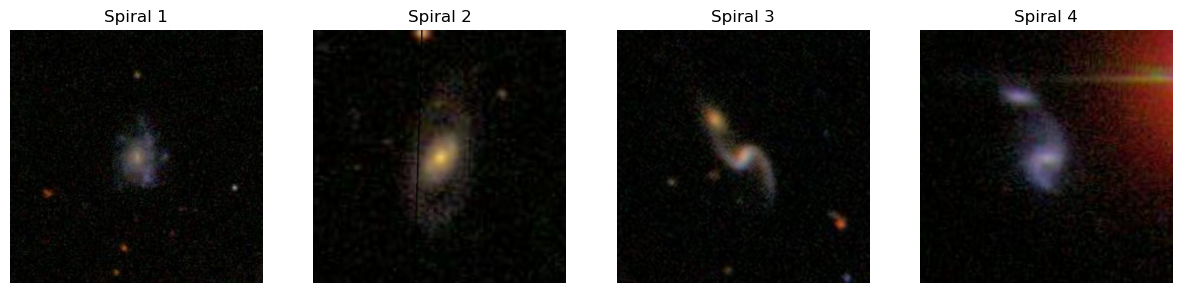


Sample non-spiral galaxy images:


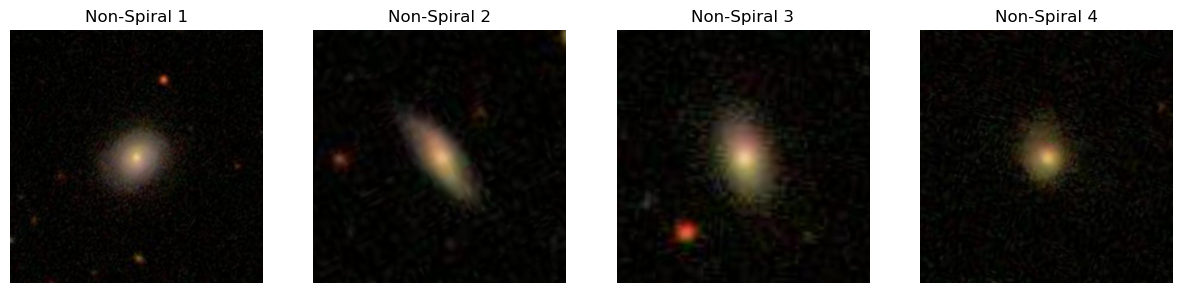

In [13]:
# Sample spiral galaxy images
print("Sample spiral galaxy images:")
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
for i, image in enumerate(os.listdir(spirals_dir)[:4]):
    img = Image.open(os.path.join(spirals_dir, image))
    ax[i].imshow(img)
    ax[i].axis('off') 
    ax[i].set_title(f"Spiral {i+1}")
plt.show()

# Sample non-spiral galaxy images
print("\nSample non-spiral galaxy images:")
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
for i, image in enumerate(os.listdir(non_spirals_dir)[:4]):
    img = Image.open(os.path.join(non_spirals_dir, image))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(f"Non-Spiral {i+1}")
plt.show()

In [16]:
# Count the number of images in each subset
subset_counts = {
    'Spiral': len(os.listdir(subset_spirals_dir)),
    'Non-Spiral': len(os.listdir(subset_non_spirals_dir))
}

# Print the counts
print(f"Number of spiral images: {subset_counts['Spiral']}")
print(f"Number of non-spiral images: {subset_counts['Non-Spiral']}")

Number of spiral images: 500
Number of non-spiral images: 500


<h1 style="color: #00BFFF;">03 | Modeling</h1>

<h3 style="color: #008080;">Getting the engines ready !</h3>

In [17]:
# Parameters that we can fine-tune later on
img_height = 180
img_width = 180 # using the same as in Keras "Image classification from scratch" tutorial
image_size = (img_height, img_width)
batch_size = 128 # using the same as in the tutorial, training utilized in each iteration

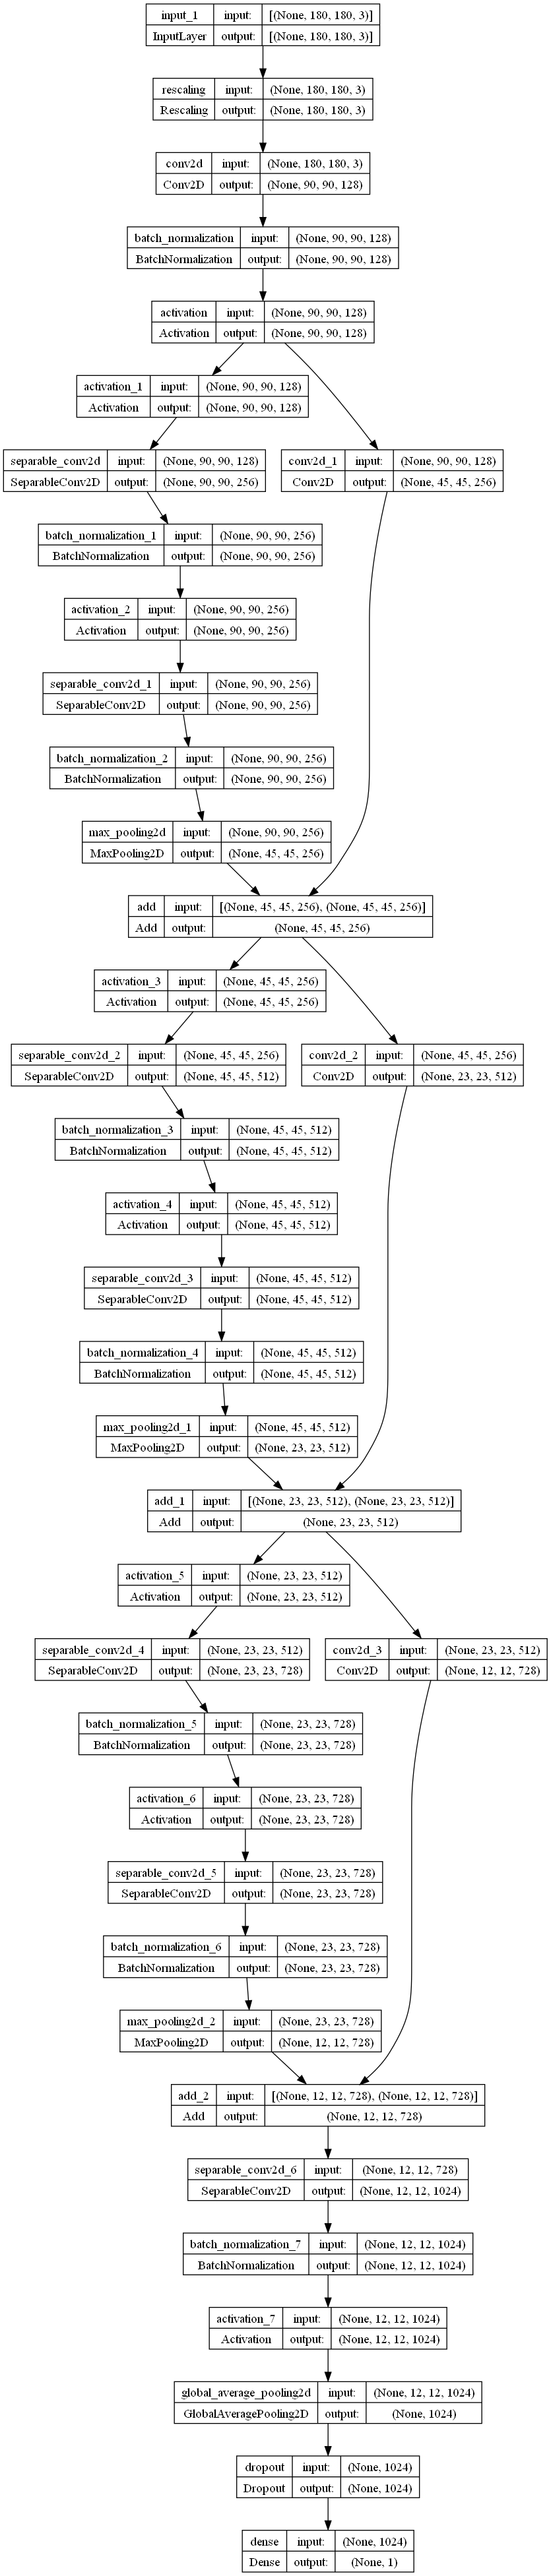

In [18]:
# Keras model, build on top of TensorFlow
model = make_model(input_shape=image_size + (3,), num_classes=2) # Image size + 3 channels of colors, 2 binary classes to predict
keras.utils.plot_model(model, show_shapes=True)

<h3 style="color: #008080;">Training Data</h3>

In [21]:
data_dir = os.path.join(data_path, "subset")

# Load your training data.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1000 files belonging to 2 classes.
Using 800 files for training.


<h3 style="color: #008080;">Test Data</h3>

In [22]:
# Load your validation data.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [29]:
# Since our final training set has 1000 images (500 spirals, 500 non spirals)
# We will first create another subset from all our test images for validation, with 1000 random unlabeled images

# Directory for the subset of test images
subset_test = os.path.join(test_images, "test_subset")
os.makedirs(subset_test, exist_ok=True) # as always 

# Subdirectory to trick Keras, creating an unknown label
unknown_dir = os.path.join(subset_test, 'unknown')
os.makedirs(unknown_dir, exist_ok=True)

image_files2 = os.listdir(test_images)
random.shuffle(image_files2) # Randomly shuffle the list

for image_file in image_files2[:1000]:
    shutil.copy(os.path.join(test_images, image_file), unknown_dir)

# First, we list all files in the directory
all_files = os.listdir(subset_test)

# If there are more than 1000 files, we will remove the excess
if len(all_files) > 1000:
    # We shuffle the list to ensure randomness
    random.shuffle(all_files)

    # We keep the first 1000 files and delete the rest
    for file in all_files[1000:]:
        os.remove(os.path.join(subset_test, file))

# ImageDataGenerator, encoding color pixel values from 0 to 255
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_ds = datagen.flow_from_directory(
    subset_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,  # This is the test data, so no labels
    shuffle=False  # Keep data in same order as filenames
)

<h3 style="color: #008080;">Training the Model. AKA --> How to crash my computer</h3>

In [23]:
# Compile and fit your model.
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [24]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

# Train your model.
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
)

7/7 [==============================] - 1208s 177s/step - loss: 0.6855 - accuracy: 0.5975 - val_loss: 0.6941 - val_accuracy: 0.4650


In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
7/7 [==============================] - 918s 124s/step - loss: 0.7033 - accuracy: 0.5938 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
7/7 [==============================] - 847s 116s/step - loss: 0.6563 - accuracy: 0.6662 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/25
7/7 [==============================] - 826s 116s/step - loss: 0.6532 - accuracy: 0.6538 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/25
7/7 [==============================] - 859s 120s/step - loss: 0.6523 - accuracy: 0.6288 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/25
7/7 [==============================] - 863s 120s/step - loss: 0.6080 - accuracy: 0.6675 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/25
7/7 [==============================] - 843s 117s/step - loss: 0.6490 - accuracy: 0.6225 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/25
7/7 [==============================] - 902s 125s/step - loss: 0.5754 - accuracy: 0.6888 - val_l

In [52]:
# And it crashed ! Luckily 🤞 they were successfully saved and we can retrieve the last one (should be the better in performance) using
from tensorflow.keras.models import load_model

<h1 style="color: #00BFFF;">04 | Model Validation</h1>

In [ ]:
# Over each epoch and iteration:
# loss is a value that should be lower in each iteration
# acurracy meaans that the model is classifying the galaxies correctly, and it should be better over time
# val_loss and val_accuracy are the metrics for unseen/test/validation data

# val_loss and val_accuracy are suspicious 0 in all epoch we can see... we will continue

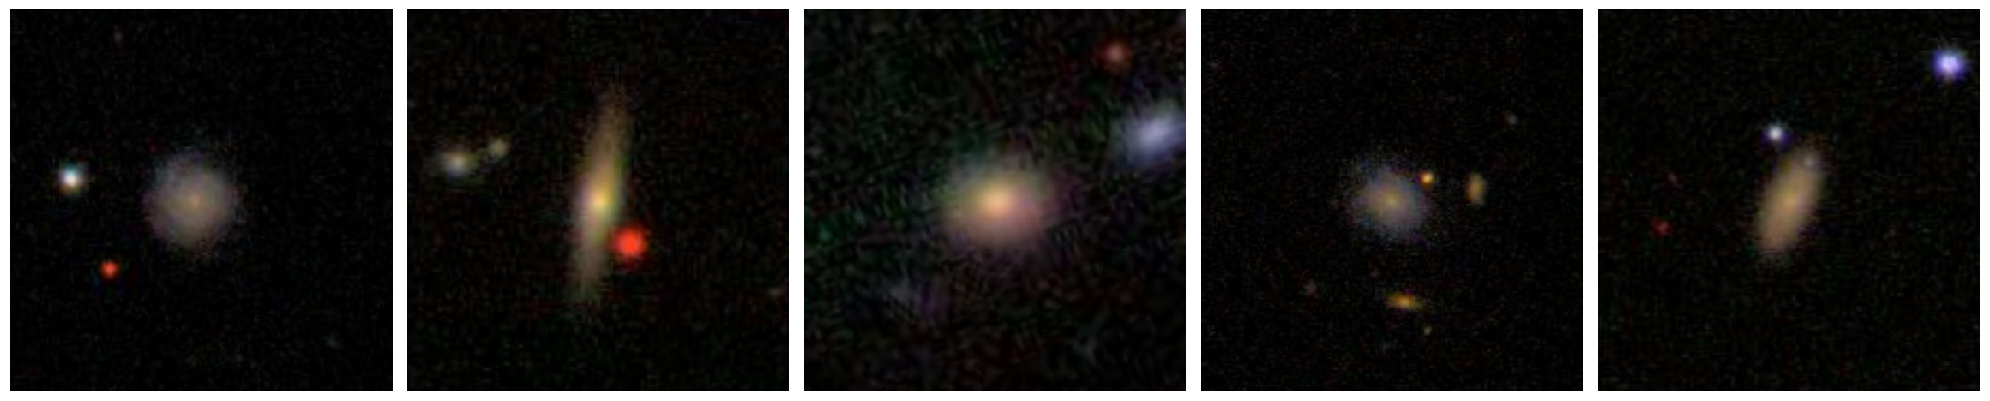

In [44]:
# Batch of images from the validation set
val_images = next(iter(val_ds))

# Plotting them
plot_images(val_images[:5])

In [1]:
# last epoch (should be the best)
model_path = "save_at_25.keras"

# loading the model
model = load_model(model_path)

In [51]:
val_predictions = model.predict(val_ds)

16/16 [==============================] - 139s 9s/step


<h1 style="color: #00BFFF;">05 | Reporting</h1>

In [30]:
image_file3 = "193255.jpg"

image_path = os.path.join(unknown_dir, image_file3)

In [58]:
# Adapted from Keras image classification from scratch
img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% class1 and {100 * score:.2f}% class2.")

1/1 [==============================] - 0s 138ms/step
This image is 50.00% class1 and 50.00% class2.


In [32]:
# Predict for the specific image
img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% spiral and {100 * score:.2f}% non-spiral.")

1/1 [==============================] - 0s 159ms/step
This image is 50.60% spiral and 49.40% non-spiral.


<h3 style="color: #008080;">Improving is an iteration process</h3>

In [ ]:
# The model had a problem indeed with the test dataset, the epoch showed val_loss and val_accuracy near 0
# AKA we will make the model better again in future versions, to fix the bug

<h3 style="color: #008080;">Bibliography</h3>

- Lintott, C. J. et al. (2008). Galaxy Zoo: Morphologies derived from visual inspection of galaxies from the Sloan Digital Sky Survey. Monthly Notices of the Royal Astronomical Society, 389(3), 1179–1189.
- Willett, K. W. et al. (2013). Galaxy Zoo 2: detailed morphological classifications for 304,122 galaxies from the Sloan Digital Sky Survey. Monthly Notices of the Royal Astronomical Society, 435(3), 2835–2860.